In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!nvidia-smi -L


GPU 0: Tesla T4 (UUID: GPU-d853e60c-1ab8-3c14-45e1-295eed7713b9)


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-06-17 06:18:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.005s  

2023-06-17 06:18:27 (36.5 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’ saved [178509/178509]



In [ ]:
data = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv" , index_col=["Date"] , parse_dates=["Date"])

In [ ]:
data.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
import matplotlib.pyplot as plt


In [ ]:
# Only want closing price for each day
df = pd.DataFrame(data["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
df.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


<Axes: xlabel='Date'>

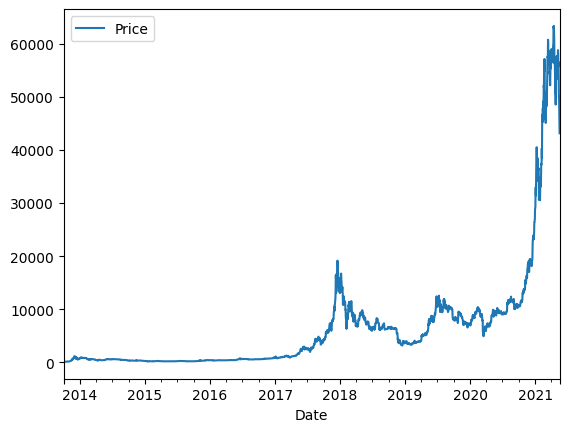

In [ ]:
df.plot(kind='line')

In [ ]:
timesteps = df.index.to_numpy()
prices = df["Price"].to_numpy()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # prices
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

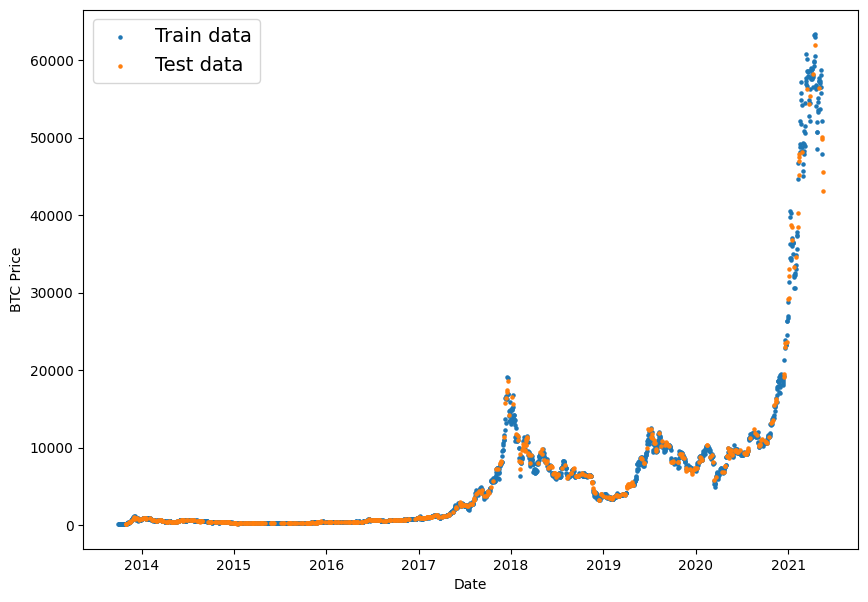

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

In [ ]:
# Train test split using the good method.


In [ ]:
def calc_results(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  if mae.ndim>0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)


  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
split_size = int(0.8 * len(prices))

In [ ]:
x_train , y_train = timesteps[:split_size] , prices[:split_size]

In [ ]:
len(x_train) , len(y_train)

(2229, 2229)

In [ ]:
x_test , y_test = timesteps[split_size:] , prices[split_size:]

In [ ]:
len(x_test ),len( y_test)

(558, 558)

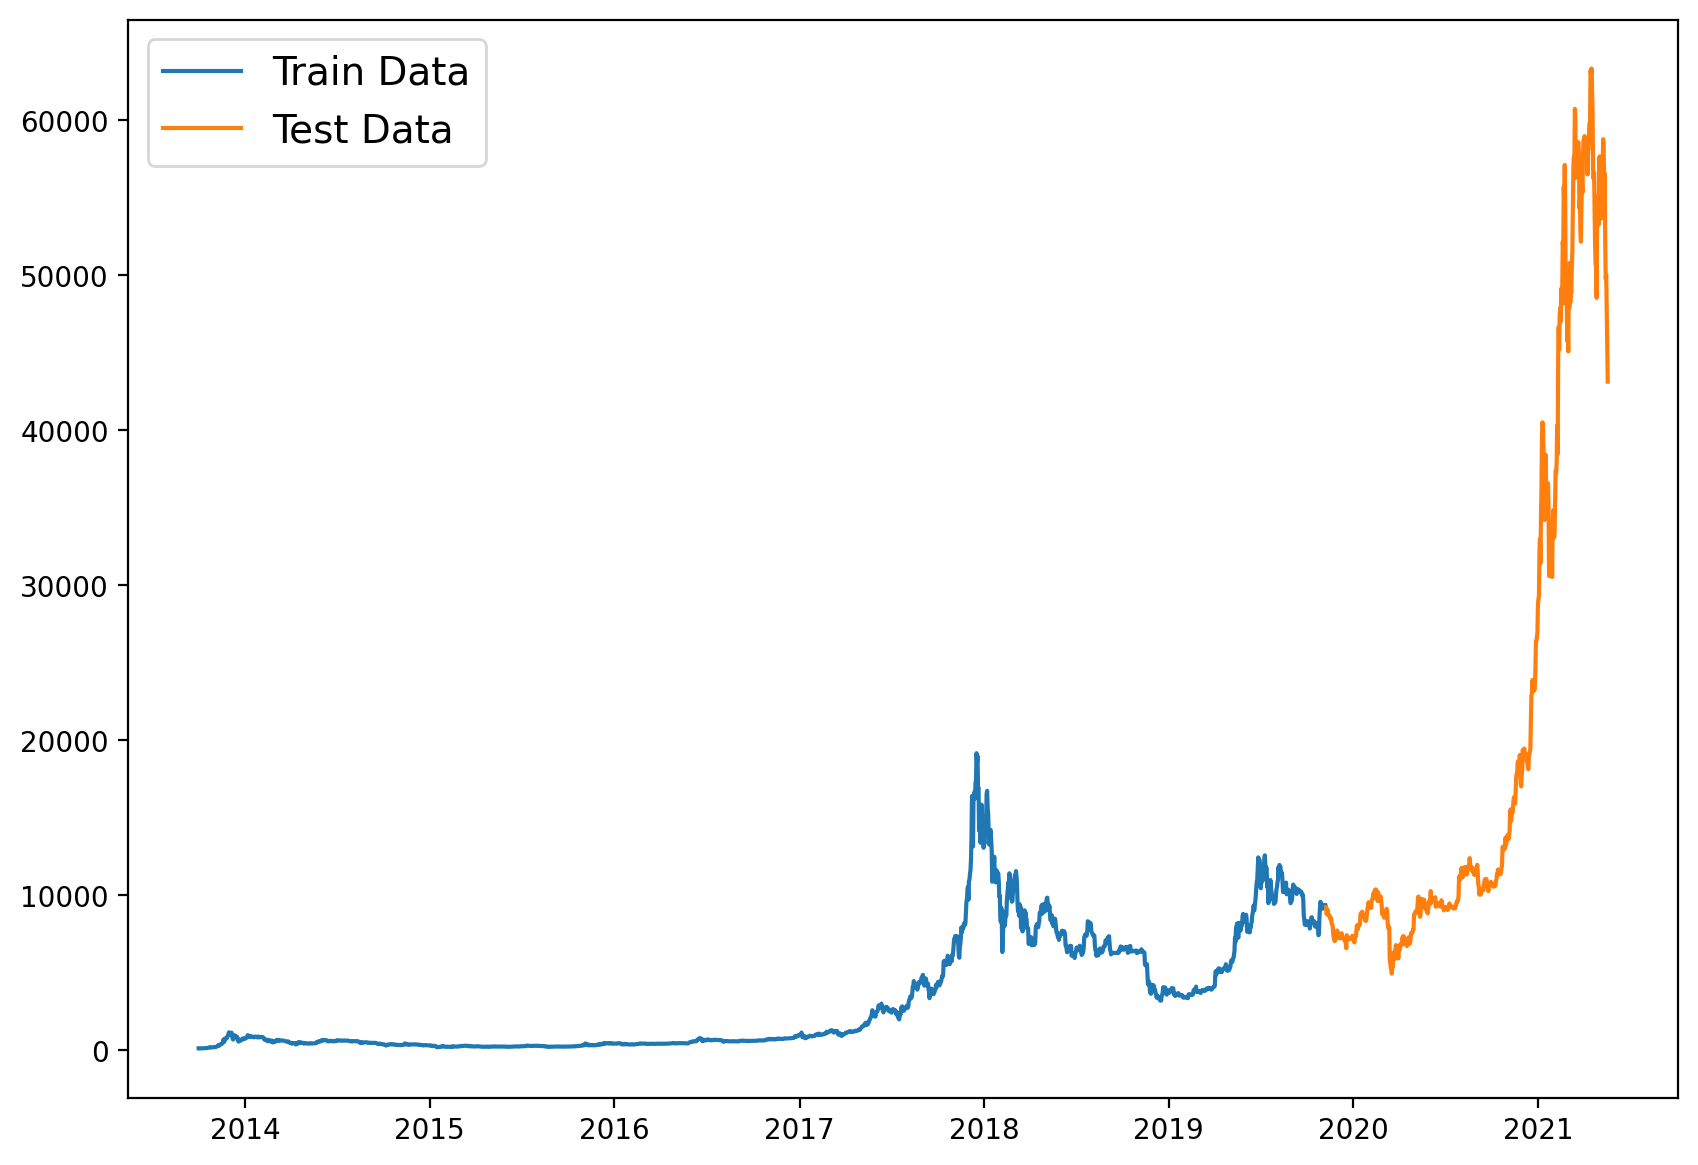

In [ ]:
plt.figure(figsize=(10,7) , dpi=200)
plt.plot(x_train , y_train , label='Train Data')
plt.plot(x_test , y_test , label="Test Data")
plt.legend(fontsize=14)



In [ ]:
def plot_graph(timesteps , prices , format="." , label=None , start =0 , end=None):
  plt.plot(timesteps[start:end] , prices[start:end] , format , label = label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

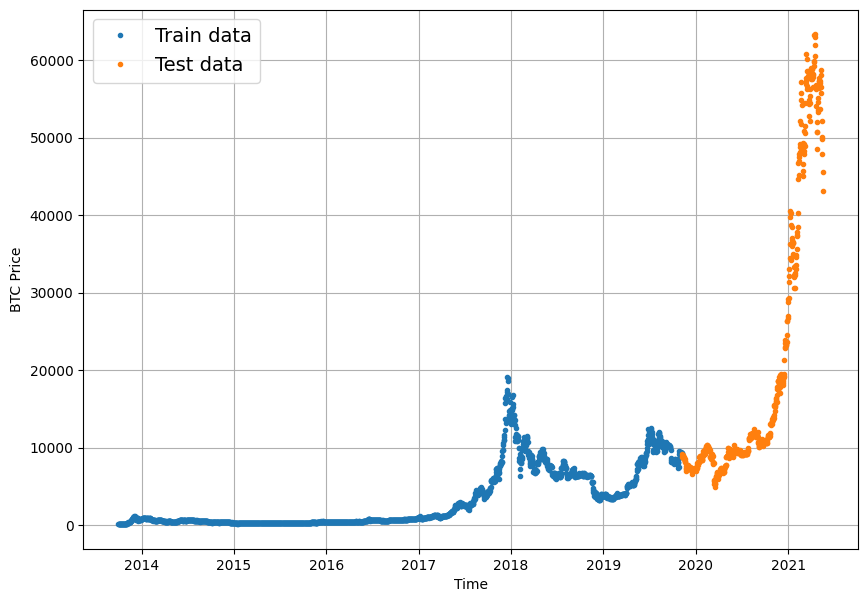

In [ ]:
plt.figure(figsize=(10, 7))
plot_graph(timesteps=x_train, prices=y_train, label="Train data")
plot_graph(timesteps=x_test, prices=y_test, label="Test data")

## Naive model


In [ ]:
naive_model = y_test[:-1]

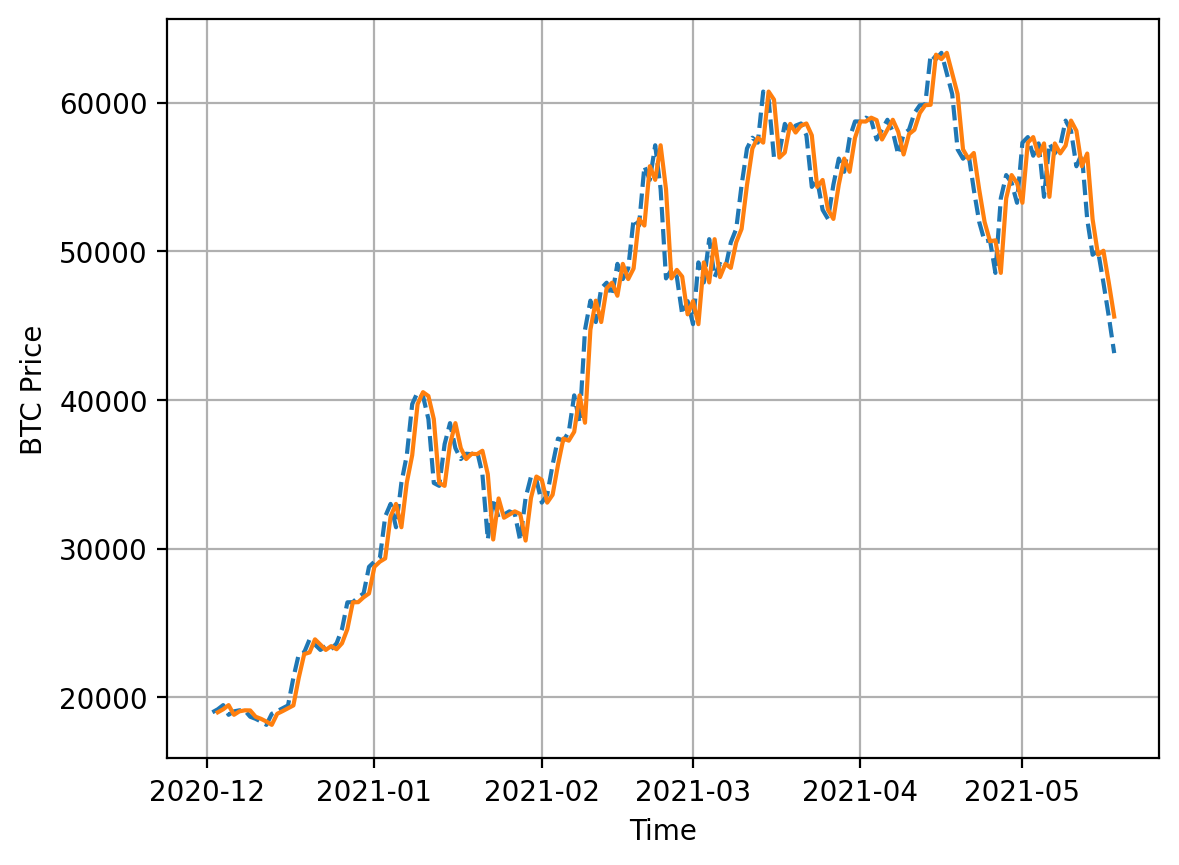

In [ ]:
plt.figure(dpi=200)
plot_graph(x_test, y_test ,start=390, format='--')
plot_graph(x_test[1:] , naive_model,start=390 , format='-')

In [ ]:
import tensorflow as tf

In [ ]:
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season




In [ ]:
naive_results = calc_results(y_test[1:] , naive_model)

In [ ]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [ ]:
def get_labelled_windows(x, horizon=1):
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
HORIZON = 1


In [ ]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [ ]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [ ]:
WINDOW_SIZE = 7
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [ ]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
import os

def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

In [ ]:
tf.random.set_seed(42)
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

In [ ]:
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

In [ ]:
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            )

Epoch 1/100
18/18 [==============================] - 5s 13ms/step - loss: 2402.3630 - mae: 2402.3630 - val_loss: 2904.8992 - val_mae: 2904.8992
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 362.2615 - mae: 362.2615 - val_loss: 1558.5294 - val_mae: 1558.5294
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 231.5793 - mae: 231.5793 - val_loss: 1102.9623 - val_mae: 1102.9623
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 192.7908 - mae: 192.7908 - val_loss: 1026.4169 - val_mae: 1026.4169
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 182.9706 - mae: 182.9706 - val_loss: 1035.4851 - val_mae: 1035.4851
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 174.5022 - mae: 174.5022 - val_loss: 960.8687 - val_mae: 960.8687
Epoch 7/100
18/18 [==============================] - 0s 4ms/step - loss: 167.8414 - mae: 167.8414 - val_loss: 957.1516 - val_mae: 957.1516
Epoch 8/100
18

In [ ]:
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 687.6807 - mae: 687.6807


[687.6806640625, 687.6806640625]

In [ ]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [ ]:
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 1ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8660.907, 8560.515, 8855.072, 8585.26 , 8511.62 , 8600.389,
        8496.168, 8298.301, 8299.021, 8345.381], dtype=float32)>)

In [ ]:
model_1_results = calc_results(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 687.68066,
 'mse': 1420072.6,
 'rmse': 1191.668,
 'mape': 3.2084558,
 'mase': 1.2080644}

In [ ]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

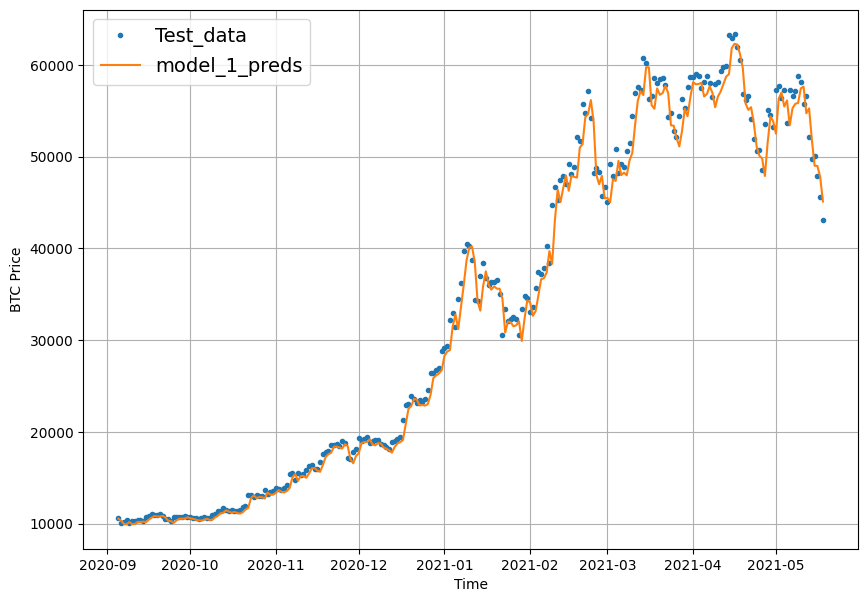

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=x_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=x_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

In [ ]:
HORIZON = 1
WINDOW_SIZE = 30

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [ ]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            )

In [ ]:
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 602.4719


602.471923828125

In [ ]:
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 602.4719


602.471923828125

In [ ]:
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 1ms/step


In [ ]:
model_2_results = calc_results(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 602.47186,
 'mse': 1252089.5,
 'rmse': 1118.968,
 'mape': 2.7127707,
 'mase': 1.0531267}

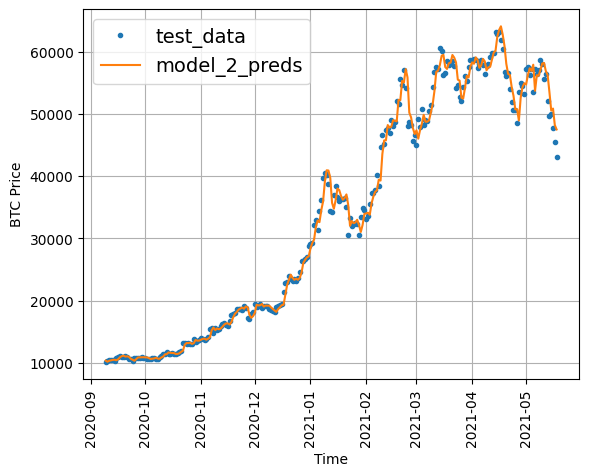

In [ ]:
offset = 300
# Account for the test_window offset
plot_time_series(timesteps=x_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=x_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")
plt.xticks(rotation=90)
plt.show()

In [ ]:
HORIZON = 7
WINDOW_SIZE = 30

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [ ]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            )

In [ ]:
model_3.evaluate(test_windows , test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1382.9701


1382.9700927734375

In [ ]:
model_3_preds = make_preds(model_3,
                           input_data=test_windows)

18/18 [==============================] - 0s 1ms/step


In [ ]:
model_3_results= calc_results(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)

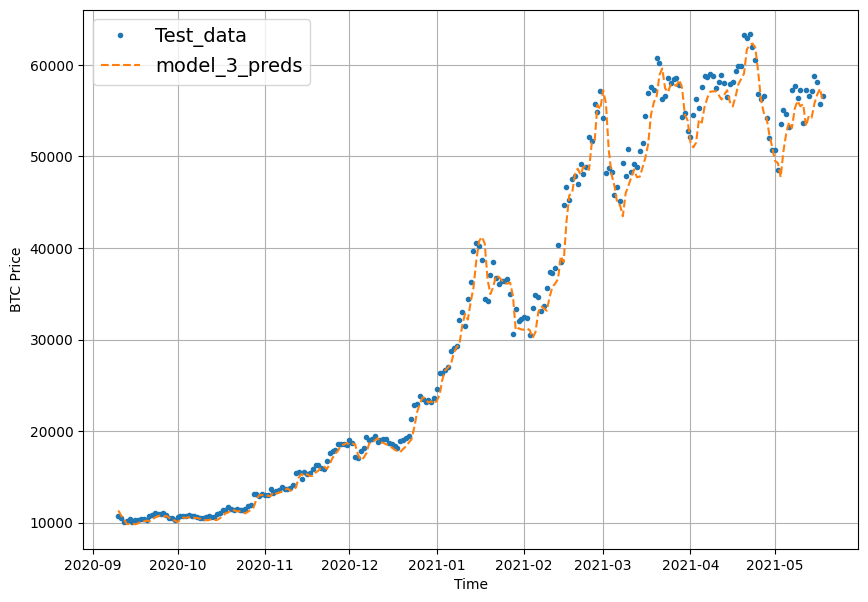

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=x_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=x_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds , axis=1), format='--',start=offset, label="model_3_preds")

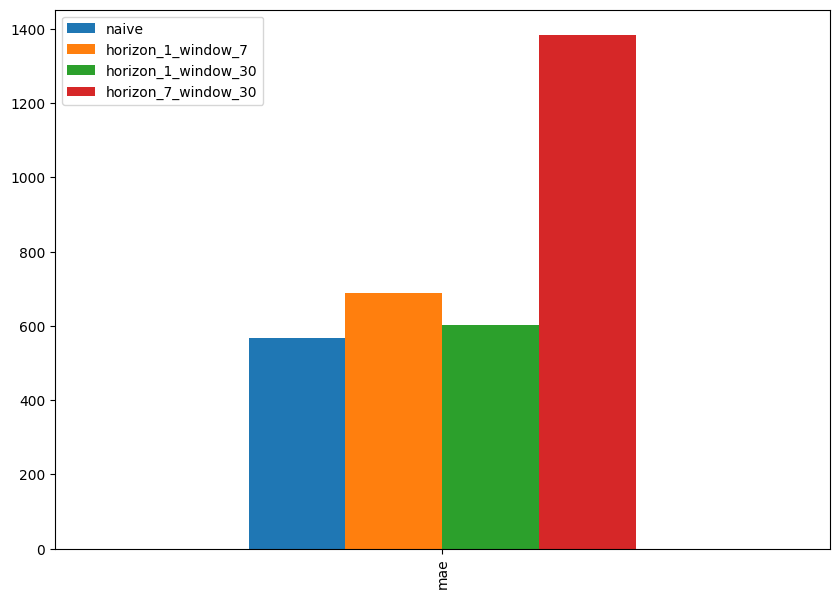

In [ ]:
results = pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

In [ ]:
results

<Axes: >

In [ ]:
window_size = 7
horizon =1

In [ ]:
full_windows , full_labels = make_windows(prices , window_size , horizon)

In [ ]:
len(full_windows) , len(full_labels)

(2780, 2780)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)


In [ ]:
train_windows[0].shape

(7,)

In [ ]:
x = tf.constant(train_windows[0])
reshape_layer = layers.Lambda(lambda  x : tf.expand_dims(x , axis=1))

In [ ]:
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    reshape_layer,
    layers.Conv1D(filters=256 , strides = 1 , kernel_size = 7 , padding = 'causal' , activation = 'relu'),
    layers.Dense(horizon)
])

In [ ]:
model_4.compile(loss= 'mae' , optimizer = tf.keras.optimizers.Adam())

In [ ]:
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels))

In [ ]:
model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 256)            12800     
                                                                 
 dense_6 (Dense)             (None, 1, 1)              257       
                                                                 
Total params: 13,057
Trainable params: 13,057
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_4.evaluate(test_windows , test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 577.5599


577.5598754882812

In [ ]:
model_1_results
#model_4_preds.shape , tf.squeeze(test_labels).shape

{'mae': 687.68066,
 'mse': 1420072.6,
 'rmse': 1191.668,
 'mape': 3.2084558,
 'mase': 1.2080644}

In [ ]:
model_4_preds = make_preds(model_4, test_windows)


18/18 [==============================] - 0s 3ms/step


In [ ]:
model_4_results = calc_results(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)

In [ ]:
model_4_results

{'mae': 577.5599,
 'mse': 1181667.6,
 'rmse': 1087.0453,
 'mape': 2.5712197,
 'mase': 1.0146127}

In [ ]:
tf.random.set_seed(42)
inputs = layers.Input(shape=(window_size))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu", return_sequences=True)(x)

x = layers.LSTM(128, activation="relu", return_sequences=True)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)

model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [ ]:
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 693.6230


693.623046875

In [ ]:
model_5_preds = make_preds(model_5, test_windows)



18/18 [==============================] - 0s 2ms/step


In [ ]:
model_5_results = calc_results(y_true=(test_labels),
                                 y_pred=tf.squeeze(model_5_preds))
model_5_results

{'mae': 693.62305,
 'mse': 1430058.9,
 'rmse': 694.2554,
 'mape': 3.2282321,
 'mase': 1.2185034}

In [ ]:
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 569.1076


569.1076049804688

In [ ]:
model_5_preds = make_preds(model_5, test_windows)


18/18 [==============================] - 0s 2ms/step


In [ ]:
model_5_results = calc_results(y_true=(test_labels),
                                 y_pred=tf.squeeze(model_5_preds))
model_5_results

{'mae': 569.1076,
 'mse': 1170252.6,
 'rmse': 569.73224,
 'mape': 2.5698972,
 'mase': 0.9997643}

In [ ]:
df.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:

block_reward_1 = 50
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25

block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [ ]:
block_reward_2_days = (block_reward_3_datetime - df.index[0]).days
block_reward_3_days = (block_reward_4_datetime - df.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [ ]:
bitcoin_prices_block = df.copy()
bitcoin_prices_block["block_reward"] = None

In [ ]:
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


In [ ]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25
2021-05-17,45604.615754,6.25
2021-05-18,43144.471291,6.25


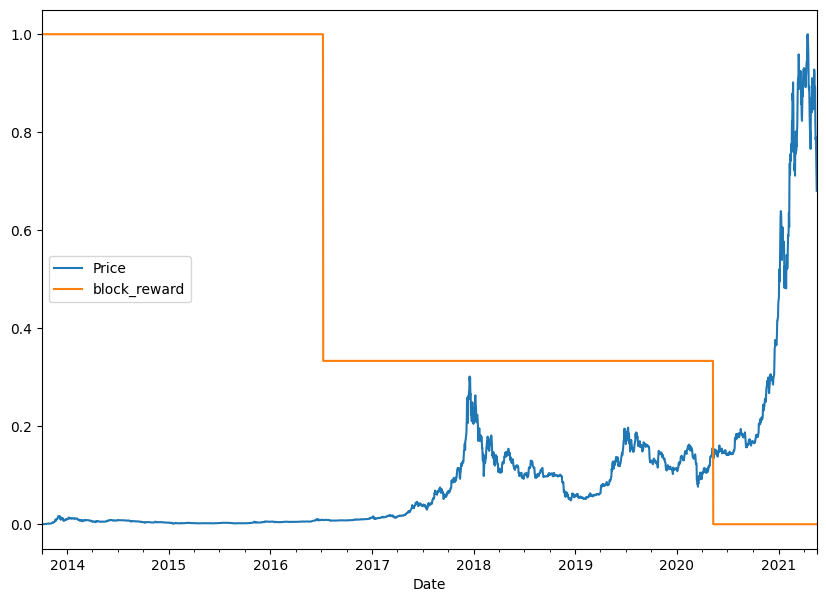

In [ ]:
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

In [ ]:
horizon = 1
window_size = 7

In [ ]:
bitcoin_prices_windowed = bitcoin_prices_block.copy()


In [ ]:
for i in range(window_size):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [ ]:
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [ ]:
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [ ]:
tf.random.set_seed(42)


tf.random.set_seed(42)
inputs = layers.Input(shape=(window_size))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu", return_sequences=True)(x)

x = layers.LSTM(128, activation="relu", return_sequences=True)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)

model_6 = tf.keras.Model(inputs  , output)

model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())


model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

ValueError: ignored

In [ ]:
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 571.2210


571.2210083007812

In [ ]:
model_6_preds = tf.squeeze(model_6.predict(X_test))


18/18 [==============================] - 0s 2ms/step


In [ ]:
y_test.shape ,(model_6_preds).shape

((556,), TensorShape([556, 7]))

In [ ]:
model_6_results = calc_results(y_true=(y_test),
                                 y_pred=tf.squeeze(model_6_preds))
model_6_results

InvalidArgumentError: ignored